# Rossmann Store Sales
Forecasting sales using store, promotion and competitor data.

In [1]:
# Basic Functionalities
import time
from pprint import pprint
from tqdm import tqdm
# Working with Data
import numpy as np
from numpy import mean
from numpy import std
import pandas as pd
# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
# Preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
# Models
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
import xgboost
# Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
# Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import RandomizedSearchCV

## 1. Data Preparation

In [2]:
train = pd.read_csv('input-rss/train.csv')
store = pd.read_csv('input-rss/store.csv')
test = pd.read_csv('input-rss/test.csv')

/var/folders/_y/hzd68ny17rsfgx2sq7wtmxcw0000gn/T/ipykernel_1345/271173482.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv('input-rss/train.csv')


In [3]:
print(store.info()) 
print(train.info())
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dty

### 1.1 Überlegungen zu den Datensätzen
1.1.1 Store
- CompetitionDistance (3 null) mit durchschnitt eintragen
- CompetitionOpenSinceMonth -> gelöscht
- CompetitionOpenSinceYear -> gelöscht
- Promo2 -> 0: kein Promo2, 
            1: Promo2 aktiv -> Promo2SinceWeek, Promo2SinceYear, PromoInterval

1.1.2 Train
- Date -> Datum; Änderung in Datetime bzw. Jahr, Monat, Tag, Woche, Tag im Jahr, Tag der Woche, Feiertag
- StateHoliday -> 0: kein Feiertag, a: Feiertag (Gesetzlich), b: Feiertag (Ostern), c: Feiertag (Christmas); Änderung in 0, 1, 2, 3
- SchoolHoliday -> 0: kein Schulferien, 1: Schulferien

### 1.2 Data Cleaning

In [4]:
store['CompetitionDistance'].fillna(store['CompetitionDistance'].mean(), inplace=True)

In [5]:
store.drop(store.columns[[4,5]], axis=1, inplace=True)

In [6]:
# map strings to categorical values
store['StoreType'] = store['StoreType'].map({'a':0, 'b':1, 'c':2, 'd':3})
store['Assortment'] = store['Assortment'].map({'a':0, 'b':1, 'c':2})
store.head()

,Store,StoreType,Assortment,CompetitionDistance,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,2,0,1270.0,0,NaN,NaN,NaN
1,2,0,0,570.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,0,0,14130.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,2,2,620.0,0,NaN,NaN,NaN
4,5,0,0,29910.0,0,NaN,NaN,NaN


In [7]:
le = LabelEncoder()
store['PromoInterval'] = le.fit_transform(store['PromoInterval'].astype(str))
store['Promo2SinceWeek'] = le.fit_transform(store['Promo2SinceWeek'].astype(str))
store['Promo2SinceYear'] = le.fit_transform(store['Promo2SinceYear'].astype(str))

In [8]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,2,0,1270.0,0,24,7,3
1,2,0,0,570.0,1,2,1,1
2,3,0,0,14130.0,1,3,2,1
3,4,2,2,620.0,0,24,7,3
4,5,0,0,29910.0,0,24,7,3


In [9]:
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [10]:
train['StateHoliday'] = le.fit_transform(train['StateHoliday'].astype(str))
print(train.head())

test['StateHoliday'] = le.fit_transform(test['StateHoliday'].astype(str))
test['Open'] = le.fit_transform(test['Open'].astype(str))
print(test.head())

   Store  DayOfWeek        Date  Sales  Customers  Open  Promo  StateHoliday  \
0      1          5  2015-07-31   5263        555     1      1             0   
1      2          5  2015-07-31   6064        625     1      1             0   
2      3          5  2015-07-31   8314        821     1      1             0   
3      4          5  2015-07-31  13995       1498     1      1             0   
4      5          5  2015-07-31   4822        559     1      1             0   

   SchoolHoliday  
0              1  
1              1  
2              1  
3              1  
4              1  
   Id  Store  DayOfWeek        Date  Open  Promo  StateHoliday  SchoolHoliday
0   1      1          4  2015-09-17     1      1             0              0
1   2      3          4  2015-09-17     1      1             0              0
2   3      7          4  2015-09-17     1      1             0              0
3   4      8          4  2015-09-17     1      1             0              0
4   5      9   

Feature Engineering: Date bei beiden in die Einzelteile aufteilen

In [11]:
# split date into year, month, day
train['Date'] = pd.to_datetime(train['Date'])
train['Date_Year'] = train['Date'].dt.year
train['Date_Month'] = train['Date'].dt.month
train['Date_Day'] = train['Date'].dt.day
train = train.drop('Date', axis=1)

# split date into year, month, day
test['Date'] = pd.to_datetime(test['Date'])
test['Date_Year'] = test['Date'].dt.year
test['Date_Month'] = test['Date'].dt.month
test['Date_Day'] = test['Date'].dt.day
test = test.drop('Date', axis=1)


In [12]:
print(train.head())
print(test.head())

   Store  DayOfWeek  Sales  Customers  Open  Promo  StateHoliday  \
0      1          5   5263        555     1      1             0   
1      2          5   6064        625     1      1             0   
2      3          5   8314        821     1      1             0   
3      4          5  13995       1498     1      1             0   
4      5          5   4822        559     1      1             0   

   SchoolHoliday  Date_Year  Date_Month  Date_Day  
0              1       2015           7        31  
1              1       2015           7        31  
2              1       2015           7        31  
3              1       2015           7        31  
4              1       2015           7        31  
   Id  Store  DayOfWeek  Open  Promo  StateHoliday  SchoolHoliday  Date_Year  \
0   1      1          4     1      1             0              0       2015   
1   2      3          4     1      1             0              0       2015   
2   3      7          4     1      1   

In [13]:
# merge train and store assortments
train = pd.merge(train, 
                 store[['StoreType', 'Assortment', 'PromoInterval', 'Promo2SinceWeek', 'Promo2SinceYear']],
                 left_on='Store', 
                 right_index=True)
test = pd.merge(test, 
                store[['StoreType', 'Assortment', 'PromoInterval', 'Promo2SinceWeek', 'Promo2SinceYear']],
                left_on='Store', 
                right_index=True)

In [14]:
print(train.describe())
print(test.describe())

              Store     DayOfWeek         Sales     Customers          Open  \
count  1.016267e+06  1.016267e+06  1.016267e+06  1.016267e+06  1.016267e+06   
mean   5.579138e+02  3.998341e+00  5.774327e+03  6.334003e+02  8.301076e-01   
std    3.216113e+02  1.997391e+00  3.850699e+03  4.645181e+02  3.755384e-01   
min    1.000000e+00  1.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    2.800000e+02  2.000000e+00  3.727000e+03  4.050000e+02  1.000000e+00   
50%    5.580000e+02  4.000000e+00  5.744000e+03  6.100000e+02  1.000000e+00   
75%    8.370000e+02  6.000000e+00  7.857000e+03  8.370000e+02  1.000000e+00   
max    1.114000e+03  7.000000e+00  4.155100e+04  7.388000e+03  1.000000e+00   

              Promo  StateHoliday  SchoolHoliday     Date_Year    Date_Month  \
count  1.016267e+06  1.016267e+06   1.016267e+06  1.016267e+06  1.016267e+06   
mean   3.815139e-01  4.516431e-02   1.786224e-01  2.013832e+03  5.846655e+00   
std    4.857585e-01  2.836569e-01   3.830360e-01

## 2. Exploratory Data Analysis

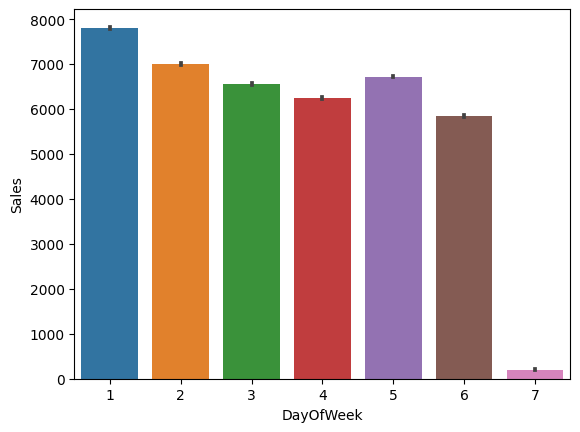

In [15]:
sns.barplot(x='DayOfWeek', y='Sales', data=train)
plt.show()

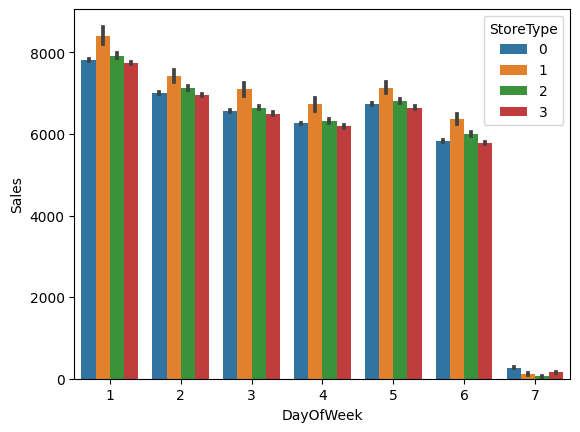

In [16]:
sns.barplot(x='DayOfWeek', y='Sales', hue='StoreType', data=train)
plt.show()

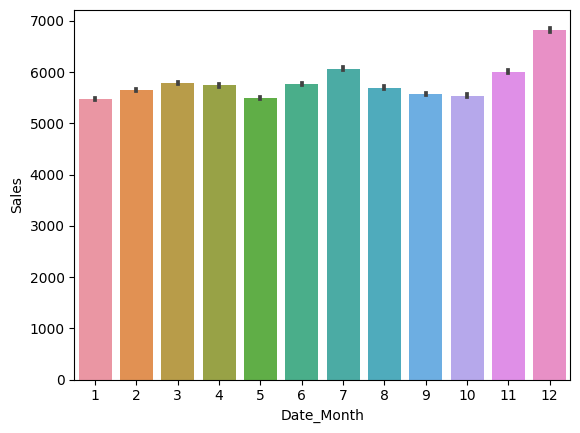

In [17]:
sns.barplot(x='Date_Month', y='Sales', data=train)
plt.show()

-> Die Umsätze sind im Dezember und Juli durschnittlich höher als im Rest des Jahres.

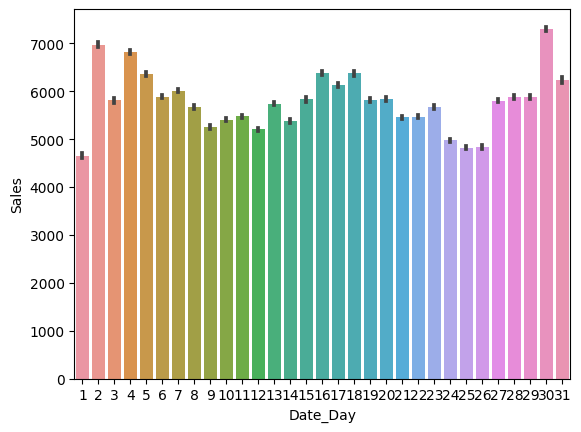

In [18]:
sns.barplot(x='Date_Day', y='Sales', data=train)
plt.show()

TODO:

In [19]:
#TODO: add more plots
#TODO: combine DayOfWeek and Date_Month

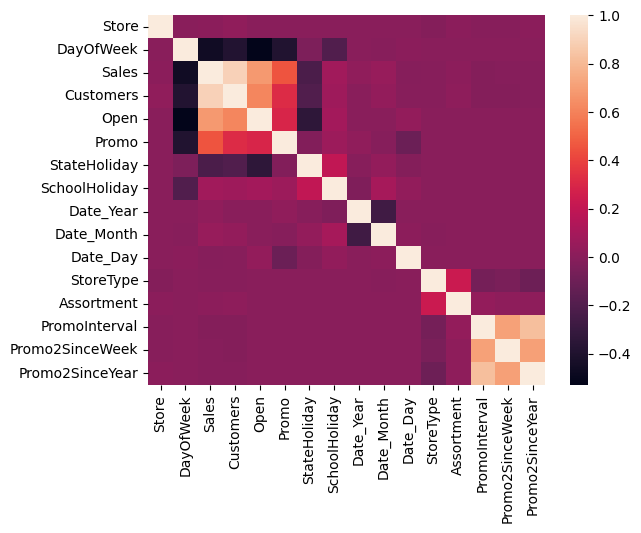

In [20]:
corr = train.corr()
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
plt.show()

<AxesSubplot: >

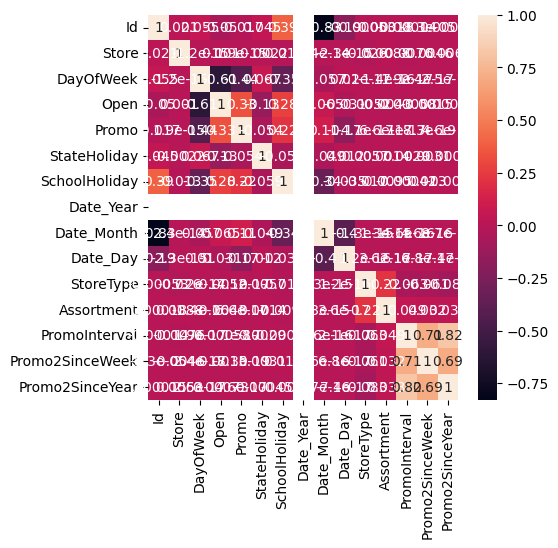

In [21]:
plt.figure(figsize=(5,5))
sns.heatmap(test.corr(),annot=True)

<AxesSubplot: >

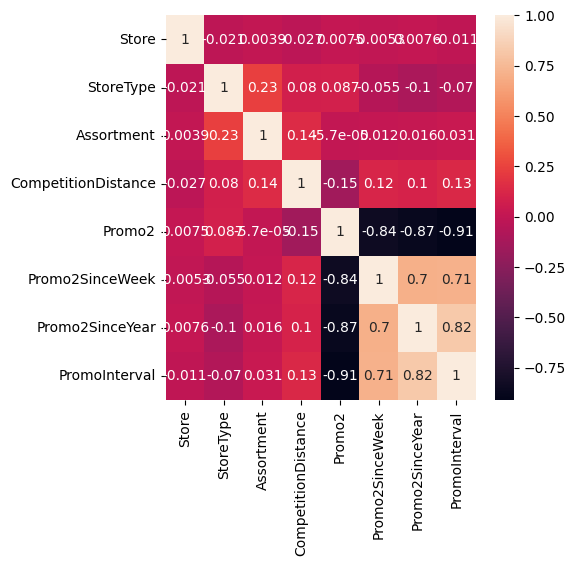

In [22]:
plt.figure(figsize=(5,5))
sns.heatmap(store.corr(),annot=True)

> Sales, Customers, Open, Promo, StateHoliday, SchoolHoliday haben eine hohe bis mäßig positive Korrelation mit Sales.

> Der Wochentag korreliert negativ mit Sales, Customers, Open, Promo, StateHoliday, SchoolHoliday.

## 3. Modelling

scaling notwendig? -> nein, vielleicht bei kNN oder SVM / XGB, doch da werden die Kennzahlen (RMSE und Average Error) wesentlich schlechter
```X = train.drop(['Sales', 'Customers'], axis=1)
y = train['Sales']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
```

In [23]:
X_train, X_test, y_train, y_test = train_test_split(train.drop(['Sales', 'Customers'], axis=1),
                                                    train['Sales'],
                                                    test_size=0.2,
                                                    random_state=42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(813013, 14)
(203254, 14)
(813013,)
(203254,)


In [24]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    
    print('Average Error: {:0.4f} degrees'.format(np.mean(errors)))
    print('RMSE = {:0.2f}'.format(np.sqrt(mean_squared_error(test_labels, predictions))))


def train_evaluate(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    print('Training set score: {:.2f}'.format(model.score(X_train, y_train)))
    print('Test set score: {:.2f}'.format(model.score(X_test, y_test)))
    evaluate(model, X_test, y_test)
    
    return model

In [25]:
# defining a function to plot feature importance
def plot_feature_importance(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)
    plt.show()

### 3.1 k-Nearest Neighbors

In [89]:
# scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler.transform(y_test.values.reshape(-1, 1))

In [90]:
knn_scaled = KNeighborsRegressor(n_neighbors=3)
knn_scaled = train_evaluate(knn_scaled, X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled)

Training set score: 0.82
Test set score: 0.64
Average Error: 0.3868 degrees
RMSE = 0.60


In [91]:
# create a k-nearest neighbors regressor
knn = KNeighborsRegressor(n_neighbors=3)

# train and evaluate the model
knn = train_evaluate(knn, X_train, y_train, X_test, y_test)

Training set score: 0.87
Test set score: 0.70
Average Error: 1403.7431 degrees
RMSE = 2123.27


Mit skalierten Daten ist die Performance des KNN eindeutig geringer, als das Training mit unskalierten Daten.

Nico's KNN hatte einen etwas besseren Wert: 
```
knn = KNeighborsRegressor(n_neighbors=7)
knn.fit(x_train, y_train)
print(knn.score(x_test, y_test))

>>> 0.9003273363217383
```
0.9003273363217383 - 0.82 = ~0.08

### 3.2 Logistic Regression

In [92]:
# create a logistic regression model
lr = LinearRegression()

# train and evaluate the model
lr = train_evaluate(lr, X_train, y_train, X_test, y_test)

Training set score: 0.54
Test set score: 0.54
Average Error: 1773.5748 degrees
RMSE = 2613.32


### 3.3 Random Forest

Training set score: 0.97
Test set score: 0.86
Average Error: 802.4904 degrees
RMSE = 1458.75


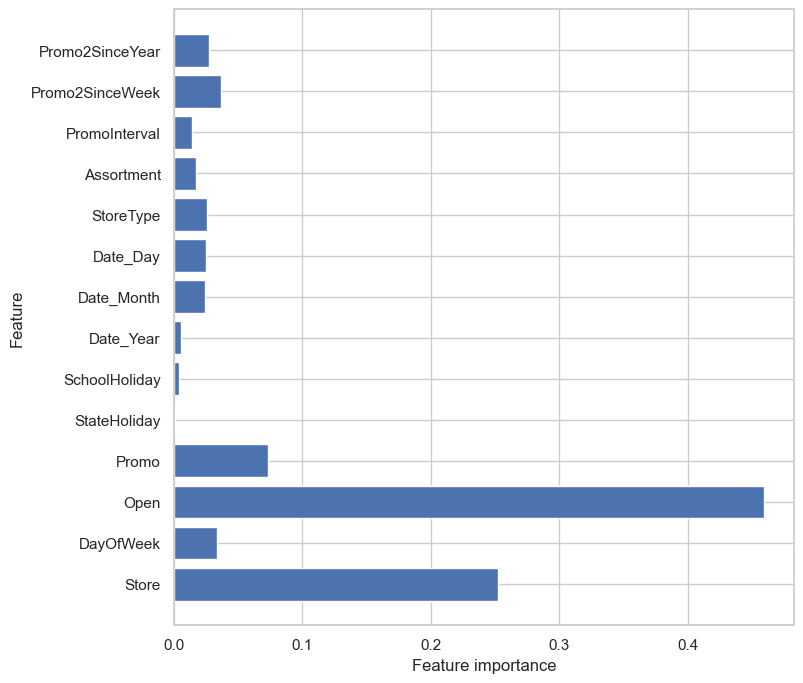

In [93]:
# create a random forest regressor
rf = RandomForestRegressor(n_estimators=5, random_state=42)

# train and evaluate the model
rf = train_evaluate(rf, X_train, y_train, X_test, y_test)

# plot feature importance
plot_feature_importance(rf)

Unterschied zu Nico:
```
rf = RandomForestRegressor(n_estimators=5, random_state=42)
rf.fit(x_train, y_train)
print(rf.score(x_test, y_test))

>>> 0.9567322397761868

### 3.4 Decision Tree

Training set score: 1.00
Test set score: 0.76
Average Error: 973.2167 degrees
RMSE = 1901.96


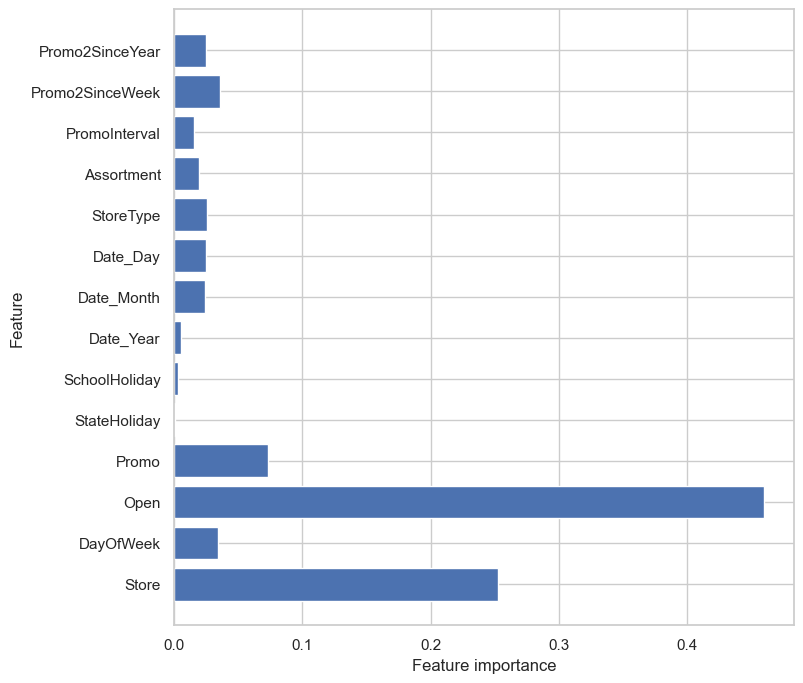

In [94]:
# create a decision tree regressor
dt = DecisionTreeRegressor(random_state=42)

# train and evaluate the model
dt = train_evaluate(dt, X_train, y_train, X_test, y_test)

# plot feature importance
plot_feature_importance(dt)

Die Performance dieses Decision Tree bei den Trainingsdaten gleicht einem Overfitting (1.00).

Unterschied zu Nico:
```
dt = DecisionTreeRegressor(min_samples_leaf=23, max_depth=27, random_state=42)
dt.fit(x_train, y_train)
print(dt.score(x_test, y_test))

>>> 0.9357382619347128

### 3.5 AdaBoost

Training set score: -0.29
Test set score: -0.29
Average Error: 3517.9819 degrees
RMSE = 4371.52


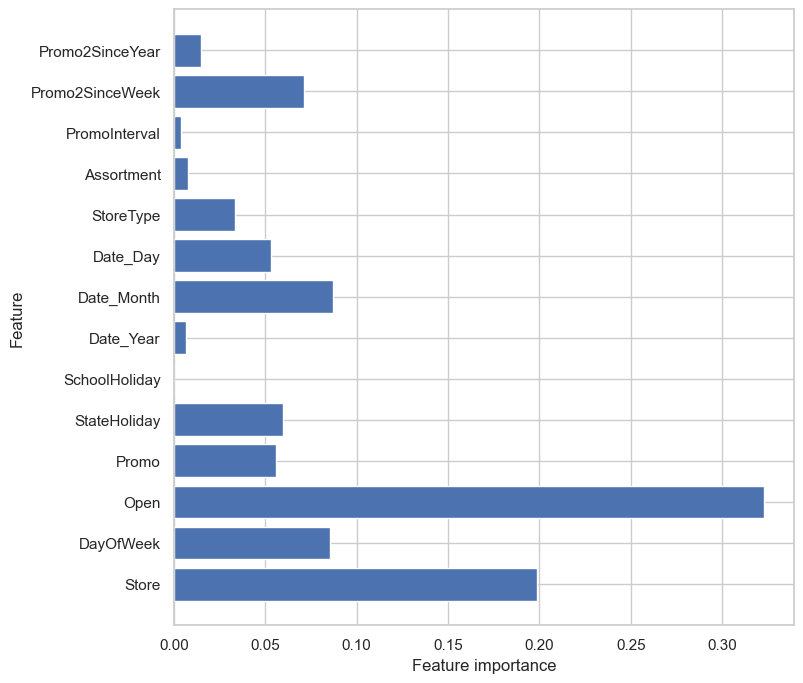

In [95]:
# create an ada boost regressor
ada = AdaBoostRegressor(random_state=42)

# train and evaluate the model
ada = train_evaluate(ada, X_train, y_train, X_test, y_test)

# plot feature importance
plot_feature_importance(ada)

Unterscheid zu Nico:
```
ada = AdaBoostRegressor(n_estimators=5, random_state=42)
ada.fit(x_train, y_train)
print(ada.score(x_test, y_test))

>>> 0.8411974934216221

### 3.6 Support Vector Machine

In [96]:
# create a support vector regressor
svr = SVR(verbose=True, max_iter=1000, tol=0.1, C=1.0, epsilon=0.2)

# train and evaluate the model
svr = train_evaluate(svr, X_train, y_train, X_test, y_test)

[LibSVM]WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1000
obj = -20806210.779413, rho = -11692.993648
nSV = 1998, nBSV = 1998


/opt/homebrew/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Training set score: -2.36
Test set score: -2.37
Average Error: 6275.1481 degrees
RMSE = 7062.80


Unterschied zu Nico:
```
pipeline_svr = make_pipeline(SVR())
print(pipeline_svr.get_params())
hyperparameters_svr = {'svr__kernel' : ['rbf'],
                        'svr__C': [0.01, 1, 10],
                        'svr__gamma': [0.01, 1, 10]}
svr_cv = GridSearchCV(pipeline_svr, hyperparameters_svr, cv=10)
svr_cv.fit(x_train, y_train)
print(svr_cv.best_params_)
print(svr_cv.best_score_)
print(svr_cv.score(x_test, y_test))

>>> Kernel ist gestorben.

Liam:

>Mit skalierten Daten crasht mir der Kernel, weshalb auf eine Skalierung verzichtet wird.

### 3.7 Gradient Boost

Training set score: 0.63
Test set score: 0.63
Average Error: 1589.0602 degrees
RMSE = 2330.91


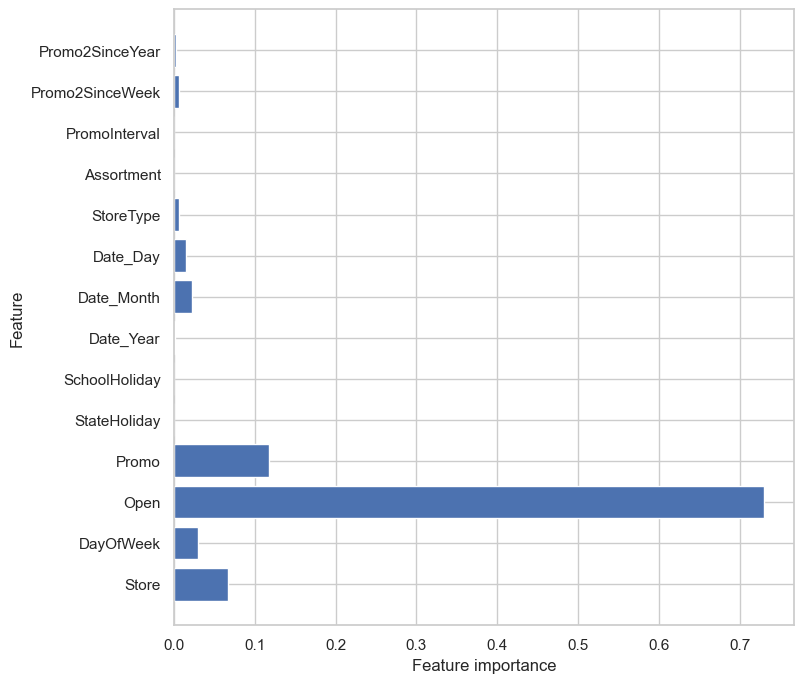

In [97]:
# create a gradient boosting regressor
gb = GradientBoostingRegressor(random_state=42)

# train and evaluate the model
gb = train_evaluate(gb, X_train, y_train, X_test, y_test)

# plot feature importance
plot_feature_importance(gb)

Unterschied zu Nico:
```
gbr = GradientBoostingRegressor(n_estimators=5, max_depth=5, random_state=42)
gbr.fit(x_train, y_train)
print(gbr.score(x_test, y_test))

>>> 0.5620337522904908

### 3.8 XGBoost

Training set score: 0.89
Test set score: 0.89
Average Error: 903.4969 degrees
RMSE = 1284.96


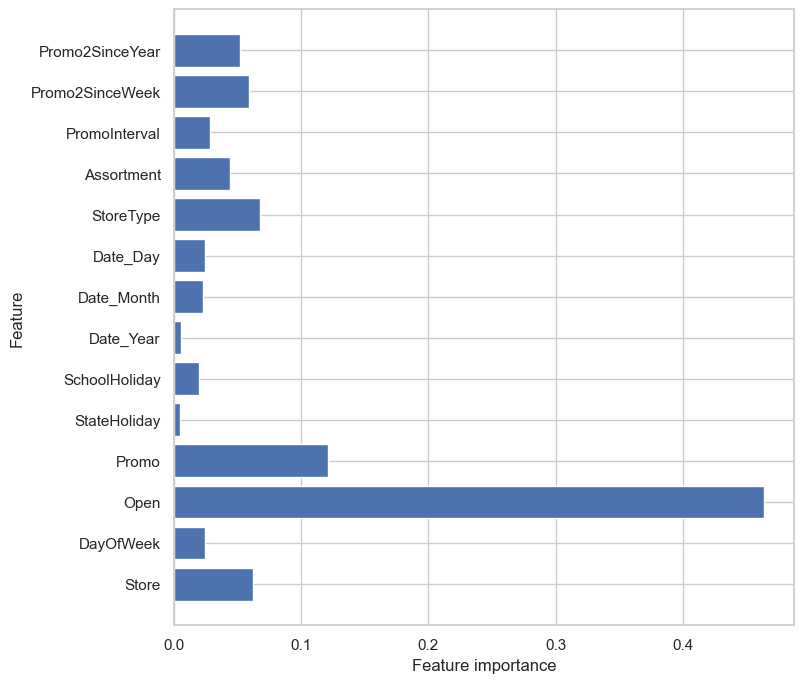

In [98]:
# create a xgboost regressor
xgb = xgboost.XGBRegressor(random_state=42)

# train and evaluate the model
xgb = train_evaluate(xgb, X_train, y_train, X_test, y_test)

# plot feature importance
plot_feature_importance(xgb)

## 4. Hyperparameter Tuning

Zuvor wurden erste Einblicke in die Feature Importance vorgenommen. Bei den Sales der Rossmann stores spielt "Open" selbstverständlich eine Schlüsselrolle. Wäre der einzelne Store geschlossen, gäbe es auch keinen Umsatz. Durchschnittlich spielt "Promo" eine - wenn auch geringe - Rolle. "StateHoliday" und "SchoolHoliday" üben hingegen keinen Einfluss auf den Umsatz aus. Bei AdaBoost und dem Decision Tree Model hat der Store Type einen vergleichsweise hohen Stellenwert. Um die Feature Importance abschließend zu bewerten, werden im nächsten Schritt die Hyperparameter einzelner Modelle optimiert:

Bevor dies geschieht, wurde die Performance der Modelle mit Standardwerten gemessen. Die Ergebnisse sind in der folgenden Tabelle zusammengefasst.
Die performantesten Modelle werden mit GridSearchCV optimiert, erkennbar an dem ☑ in der Spalte "Hyperparameter Tuning?".

| Model      | Performance | Hyperparameter Tuning?     |
| ---:        |    :----   |          :---: |
| k=3-Nearest Neighbors      | Training set score: 0.87<br>Test set score: 0.70<br>Average Error: 1403.7431 degrees.<br>RMSE = 2123.27| ☑ |
| Logistic Regression   |Training set score: 0.54<br>Test set score: 0.54<br>Average Error: 1773.5748 degrees.<br>RMSE = 2613.32|ist im Mittelfeld, daher (vorerst nicht)|
| Random Forest   |Training set score: 0.97<br>Test set score: 0.86<br>Average Error: 802.4904 degrees.<br>RMSE = 1458.75| ☑ |
| Decision Tree   |Training set score: 1.00<br>Test set score: 0.76<br>Average Error: 973.2167 degrees.<br>RMSE = 1901.96| ☑ |
| AdaBoost   |Training set score: -0.29<br>Test set score: -0.29<br>Average Error: 3517.9819 degrees.<br>RMSE = 4371.52|bildet das Schlusslicht|
| Support Vector Machine   |Training set score: -0.42<br>Test set score: -0.42<br>Average Error: 3674.5290 degrees.<br>RMSE = 4587.11|bildet das Schlusslicht|
| Gradient Boost   |Training set score: 0.63<br>Test set score: 0.63<br>Average Error: 1589.0602 degrees.<br>RMSE = 2330.91|ist im Mittelfeld, daher (vorerst nicht)|
| XGBoost   |Training set score: 0.89<br>Test set score: 0.89<br>Average Error: 903.4969 degrees.<br>RMSE = 1284.96| ☑ |

Nach der Optimierung soll die Performance der einzelnen Modelle mit den Testdaten gemessen werden. Außerdem wird die Feature Importance der einzelnen Modelle nochmals betrachtet - sofern möglich. Die Darstellung der "Actual VS Predicted Sales" erfolgte zunächst mit dem Seaborn Scatterplot, später wird das regplot getestet.

In [48]:
# define a function to plot predicted vs actual values
def plot_predicted_vs_actual(model):
    # cross_val_predict returns an array of the same size as `y` where each entry
    # is a prediction obtained by cross validation:
    predicted = cross_val_predict(model, X_test, y_test, cv=10)

    #fig, ax = plt.subplots()
    #ax.scatter(y_test, predicted, edgecolors=(0, 0, 0))
    #ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    
    #plt.show()

    sns.set_theme(style="whitegrid")
    plt.style.use('fivethirtyeight')

    plt.figure(figsize=(12,12))
    sns.regplot(x=y_test, y=predicted, truncate=True, scatter_kws={'alpha': 0.1, 's':2}, line_kws={'alpha': 0.5, 'label':'Regression Line', 'color':'#272727'}, label='Predicted Sales')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], lw=2, label='Perfect Prediction', color='#ab2425', alpha=.5)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.legend()

    title = '{}: Actual vs Predicted Sales'.format(type(model).__name__)
    sig1 = '__________________________________________________________________________________________________________'
    
    sig2 = '   © NICO BORKOWSKI & LIAM WANDER                                                                                                      Source: Rossmann   '
    plt.title(title, fontsize=26, weight='bold', alpha=.75)
    plt.gcf().text(0.02, 0.02, sig1, fontsize=14, color = 'grey', alpha = .7)
    plt.gcf().text(0.01, 0, sig2, fontsize=14, color = 'grey', alpha = .7)

    plt.show()

### 4.1 Tuning k-Nearest Neighbors

Fitting 5 folds for each of 14 candidates, totalling 70 fits
{'n_neighbors': 2}


100%|██████████| 14/14 [06:05<00:00, 26.10s/it]


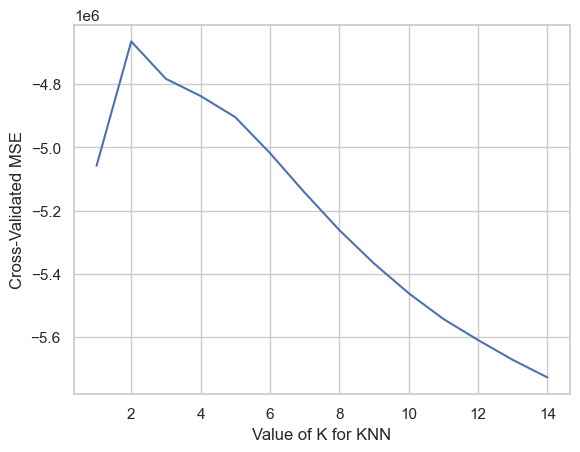

In [100]:
knn = KNeighborsRegressor()

# create a dictionary of all values we want to test for n_neighbors
param_grid = {'n_neighbors': np.arange(1, 15)}

# use gridsearch to test all values for n_neighbors
knn_gscv = GridSearchCV(knn, param_grid, cv=5, verbose=1)
knn_gscv.fit(X_train, y_train)

# check top performing n_neighbors value
pprint(knn_gscv.best_params_)

# plot the value of K for KNN (x-axis) versus the cross-validated accuracy (y-axis)
k_range = range(1, 15)
k_scores = []
for k in tqdm(k_range):
    knn = KNeighborsRegressor(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
    k_scores.append(scores.mean())

plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated MSE')
plt.show()

Best K=2 Neighbors. Alles 'drunter und drüber ist weitaus weniger performant.

Training set score: 0.92
Test set score: 0.71
Average Error: 1298.0292 degrees
RMSE = 2070.58


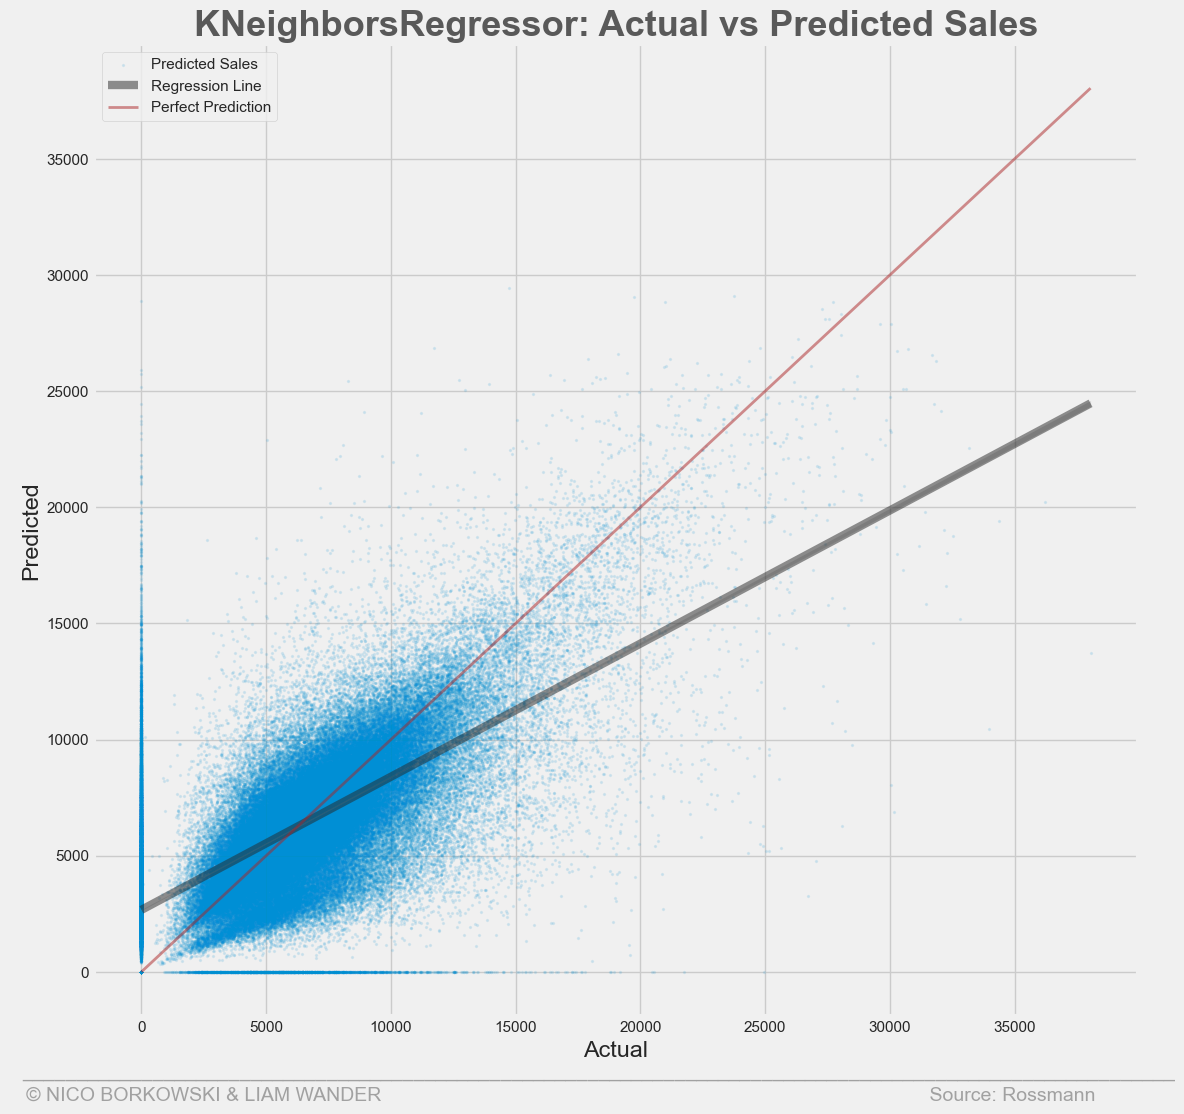

In [49]:
# create a k-nearest neighbors regressor using the best parameter
knn = KNeighborsRegressor(n_neighbors=2)

# train and evaluate the model
knn = train_evaluate(knn, X_train, y_train, X_test, y_test)

# plot predicted vs actual values
plot_predicted_vs_actual(knn)

### 4.2 Tuning the Random Forest

```# create a random forest regressor
rf = RandomForestRegressor(random_state=42)

# create a dictionary of all values we want to test for n_estimators
param_grid = {'n_estimators': [50, 100, 200],
              'max_features': ['sqrt', 'log2', 'None'],
              'max_depth': [9, 12, 15],
              'max_leaf_nodes': [9, 12, 15]}

# use gridsearch to test all values for n_estimators
rf_gscv = GridSearchCV(rf, param_grid, cv=5, verbose=2)

# fit model to data
rf_gscv.fit(X_train, y_train)

# check top performing n_estimators value
pprint(rf_gscv.best_params_)

```
/opt/homebrew/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
135 fits failed out of a total of 405.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
135 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_forest.py", line 341, in fit
    self._validate_params()
  File "/opt/homebrew/lib/python3.10/site-packages/sklearn/base.py", line 570, in _validate_params
    validate_parameter_constraints(
  File "/opt/homebrew/lib/python3.10/site-packages/sklearn/utils/_param_validation.py", line 97, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'max_features' parameter of RandomForestRegressor must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'log2', 'auto' (deprecated), 'sqrt'} or None. Got 'None' instead.

  warnings.warn(some_fits_failed_message, FitFailedWarning)
/opt/homebrew/lib/python3.10/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [0.5325943  0.53726969 0.5391543  0.54620291 0.54804783 0.54938272
 0.5541346  0.55579528 0.55641082 0.5325943  0.53726969 0.5391543
 0.54620291 0.54804783 0.54938272 0.5541346  0.55579528 0.55641082
        nan        nan        nan        nan        nan        nan
        nan        nan        nan 0.5325943  0.53726969 0.5391543
 0.54620291 0.54804783 0.54938692 0.55398947 0.5557231  0.55645482
 0.5325943  0.53726969 0.5391543  0.54620291 0.54804783 0.54938692
 0.55398947 0.5557231  0.55645482        nan        nan        nan
        nan        nan        nan        nan        nan        nan
 0.5325943  0.53726969 0.5391543  0.54620291 0.54804783 0.54938692
 0.55398947 0.5557231  0.55645482 0.5325943  0.53726969 0.5391543
 0.54620291 0.54804783 0.54938692 0.55398947 0.5557231  0.55645482
        nan        nan        nan        nan        nan        nan
        nan        nan        nan]
  warnings.warn(
{'max_depth': 12,
 'max_features': 'sqrt',
 'max_leaf_nodes': 15,
 'n_estimators': 200}
 ```

Training set score: 0.56
Test set score: 0.56
Average Error: 1750.0507 degrees
RMSE = 2555.33


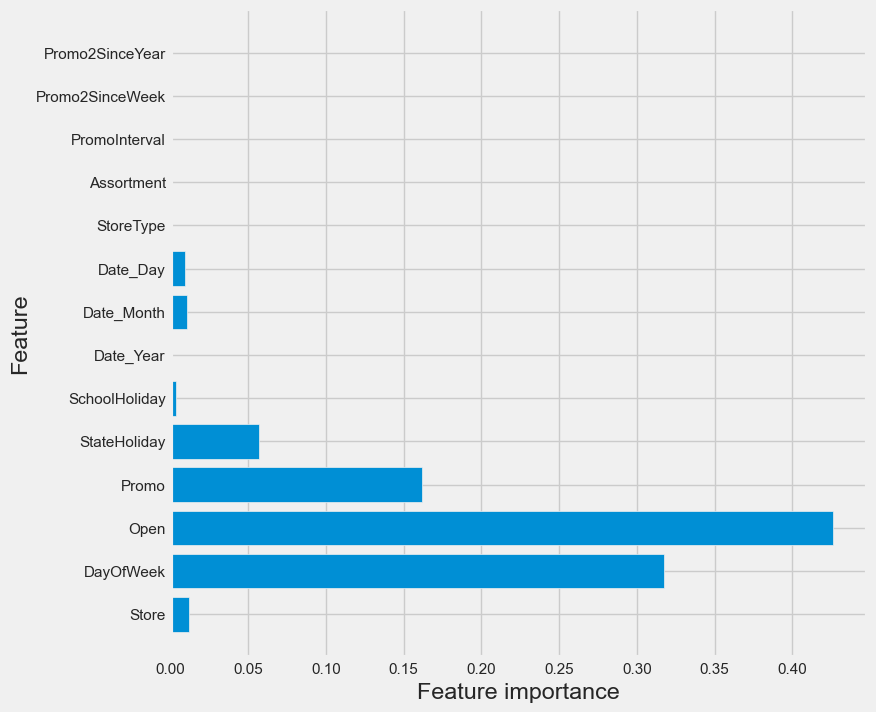

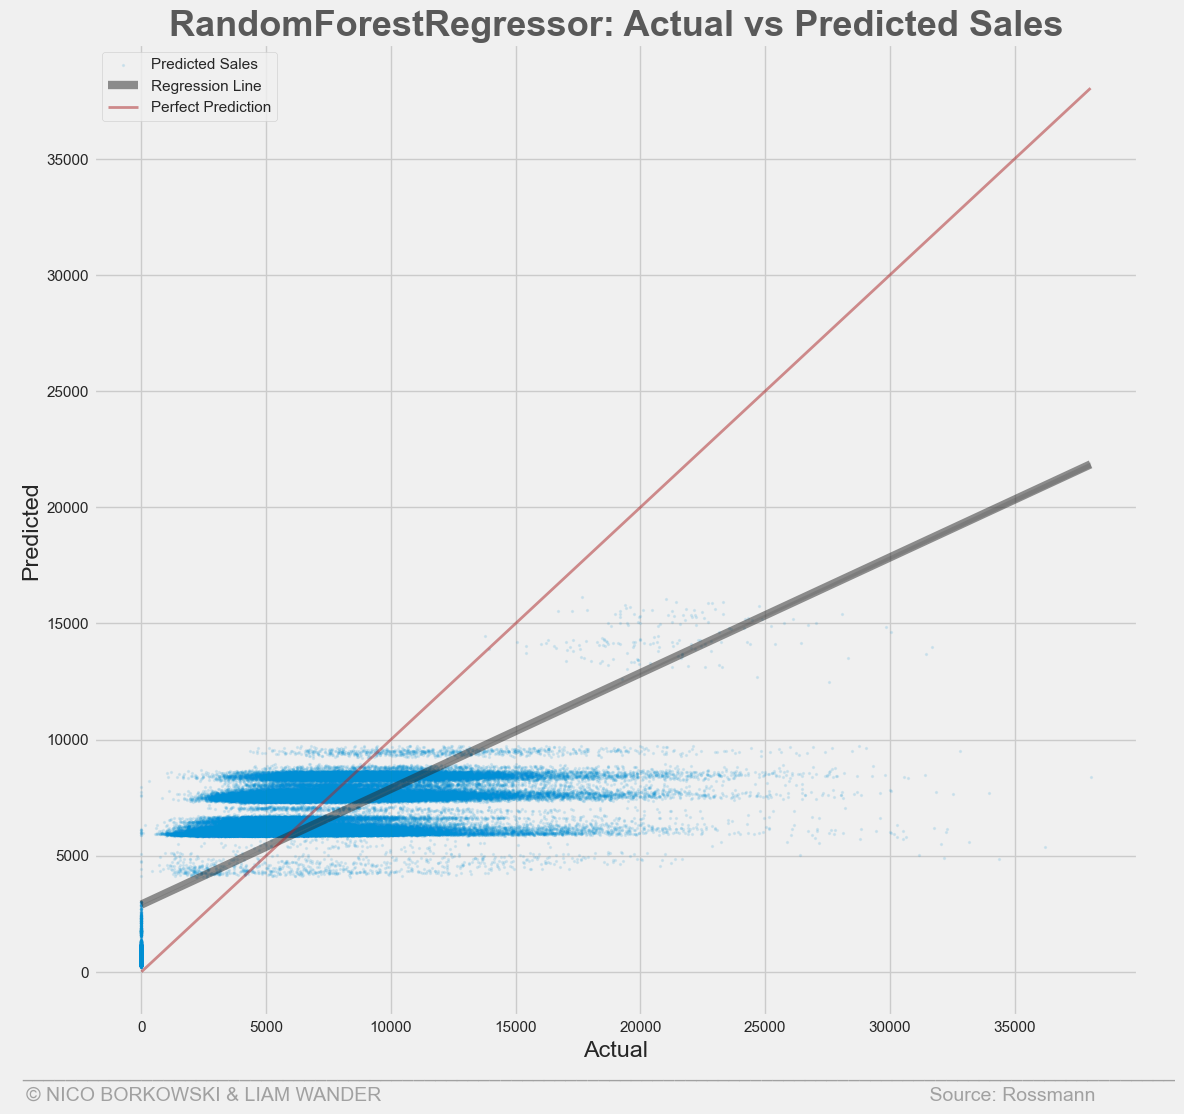

In [51]:
rf = RandomForestRegressor(n_estimators=200, max_features='sqrt', max_depth=12, max_leaf_nodes=15, random_state=42)
rf = train_evaluate(rf, X_train, y_train, X_test, y_test)

plot_feature_importance(rf)
plot_predicted_vs_actual(rf)

Nach der Optimierung der Hyperparameter ist die Performance des Random Forests deutlich gesunken, der Root Mean Squared Error liegt bei 2555.33$“. Auch die Feature Importance lässt zu Wünschen übrig: Der Umsatz ist nach wie vor von der Öffnung und dem Wochentag abhängig.

```
rf = RandomForestRegressor(random_state=42)
param_grid = {'n_estimators': [50, 100, 200, 300, 400, 500],
              'max_features': ['sqrt', 'log2', 'None'],
              'max_depth': [9, 12, 15, 18, 21, 24],
              'max_leaf_nodes': [9, 12, 15, 18, 21, 24]}

random_search = RandomizedSearchCV(rf, param_distributions=param_grid, n_iter=10, cv=5, verbose=2)

random_search.fit(X_train, y_train)
pprint(random_search.best_params_)

Training set score: 0.57
Test set score: 0.57
Average Error: 1711.4060 degrees
RMSE = 2521.01


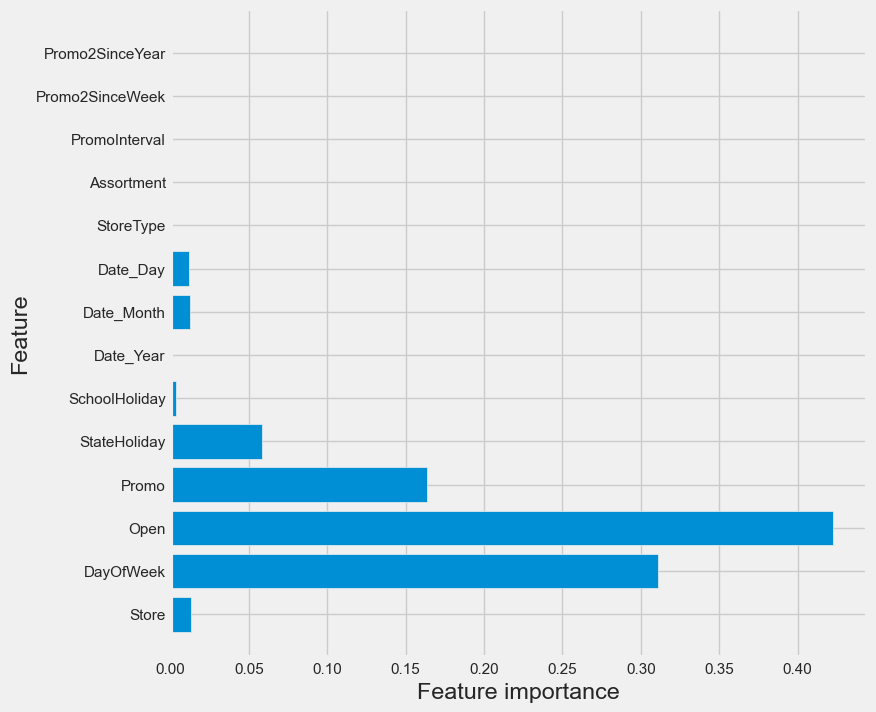

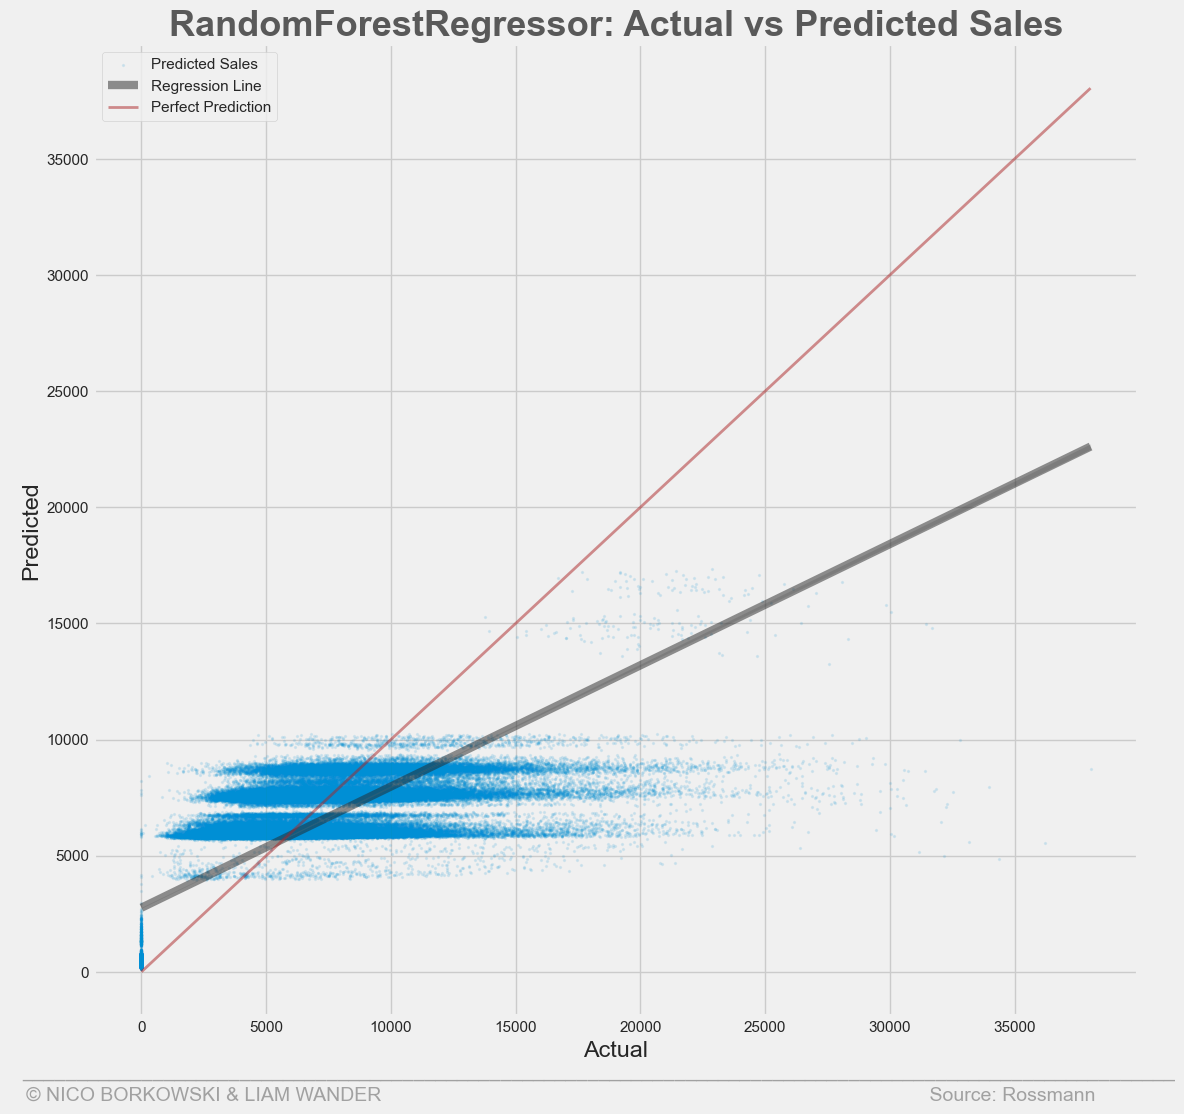

In [50]:
rf = RandomForestRegressor(n_estimators=300, max_features='log2', max_depth=12, max_leaf_nodes=24, random_state=42)
rf = train_evaluate(rf, X_train, y_train, X_test, y_test)
plot_feature_importance(rf)
plot_predicted_vs_actual(rf)

Training set score: 0.98
Test set score: 0.89
Average Error: 704.8334 degrees
RMSE = 1291.30


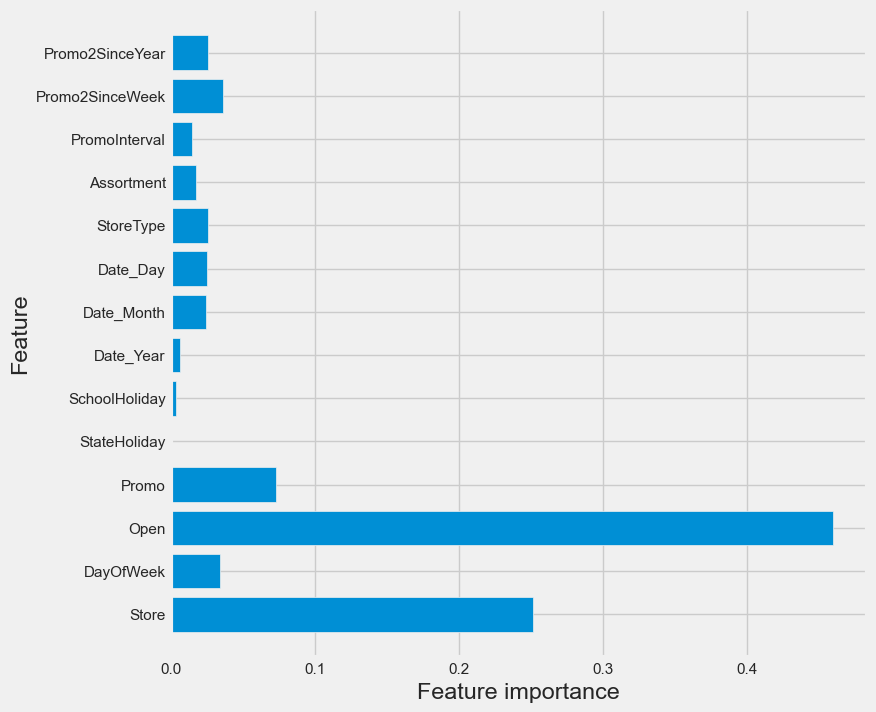

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


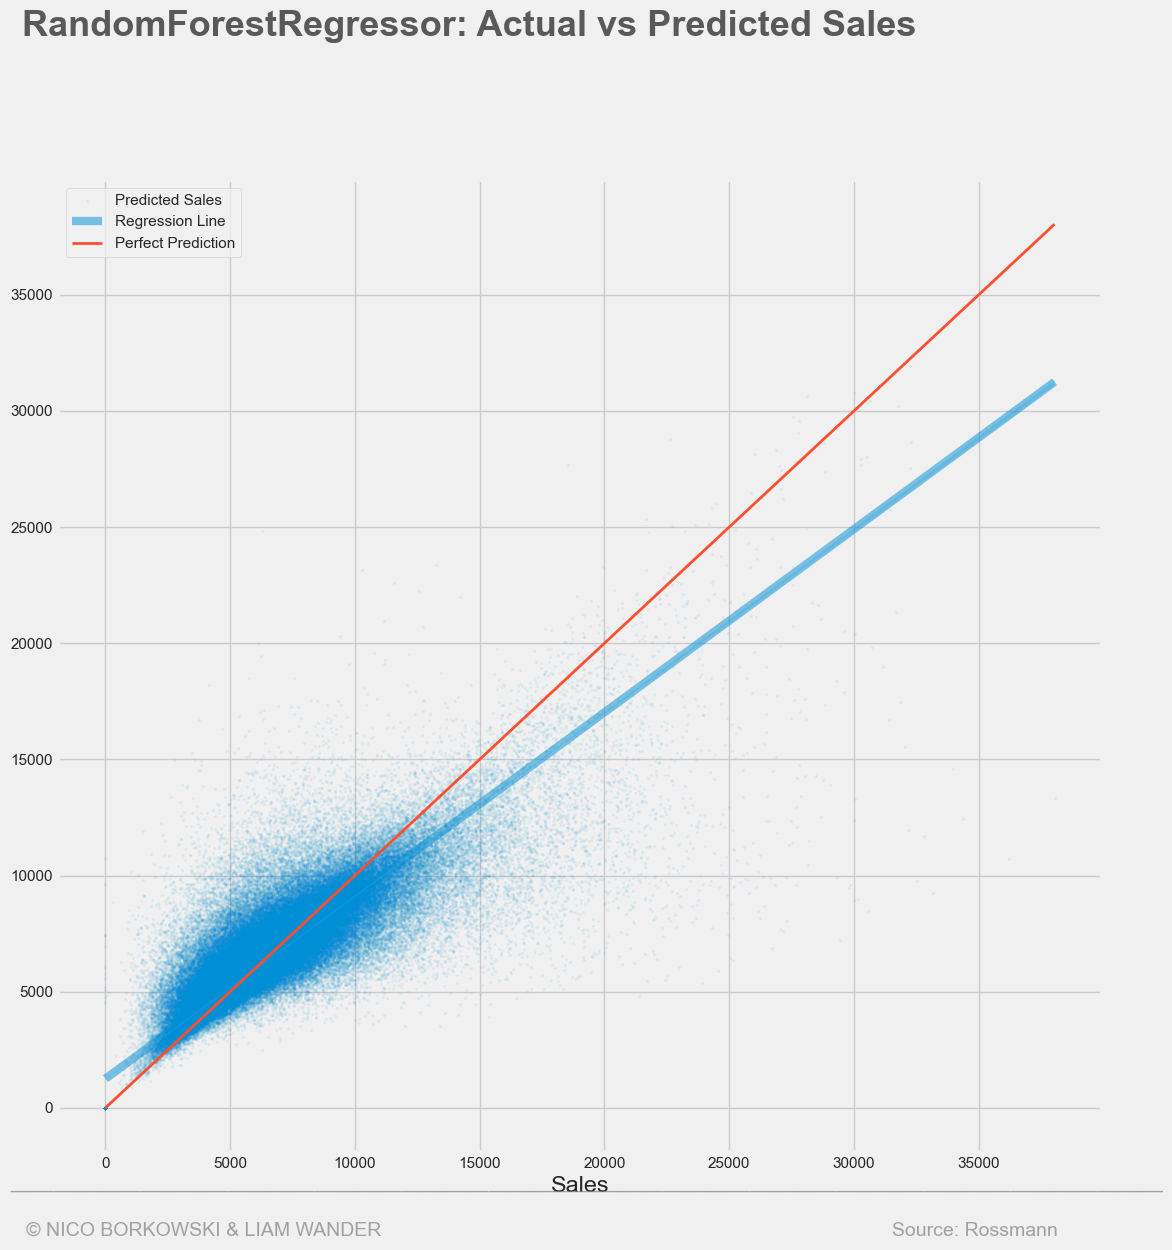

In [30]:
# print standard parameters of a random forest
rf = RandomForestRegressor(random_state=42)
rf = train_evaluate(rf, X_train, y_train, X_test, y_test)

plot_feature_importance(rf)
pprint(rf.get_params())
plot_predicted_vs_actual(rf)

-> Mit den Standardwerten des Random Forests werden mit Abstand die besten Werte erzielt

### 4.3 Tuning the Decision Tree

Training set score: 1.00
Test set score: 0.76
Average Error: 973.2167 degrees
RMSE = 1901.96


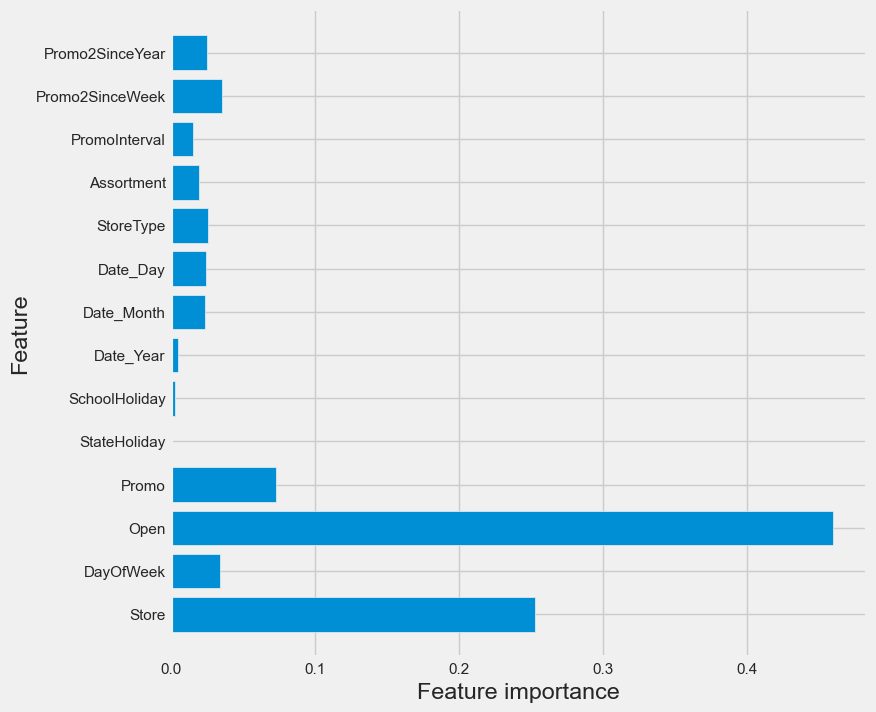

In [52]:
dt = DecisionTreeRegressor(random_state=42)
dt = train_evaluate(dt, X_train, y_train, X_test, y_test)
plot_feature_importance(dt)

```# optimize the decision tree regressor

# create a decision tree regressor
dt = DecisionTreeRegressor(random_state=42)

# create a dictionary of all values we want to test for max_depth
parameters = {'criterion': ['poisson', 'friedman_mse', 'squared_error'], 
              'max_depth': [2,4,6,8,10], 
              'max_features': [1,3,5,7,10,15,20],                
              'min_samples_split': [2,3,4,5,6,7]}
# use gridsearch to test all values for n_estimators
dt_gscv = GridSearchCV(dt, parameters, cv=5, verbose=2)

# fit model to data
dt_gscv.fit(X_train, y_train)

pprint(dt_gscv.best_params_)

Training set score: 0.60
Test set score: 0.61
Average Error: 1598.4253 degrees
RMSE = 2416.45


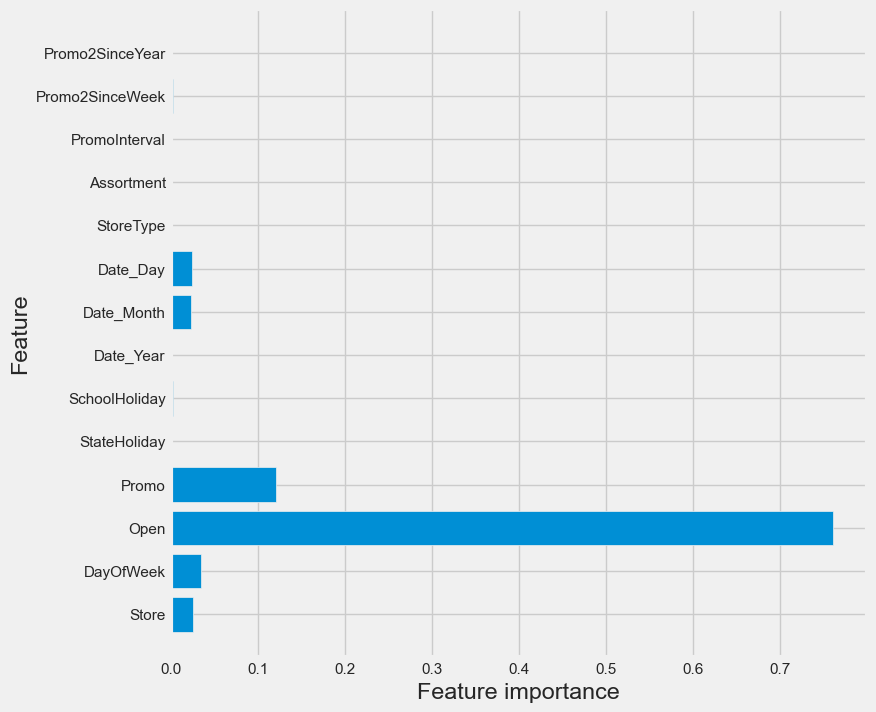

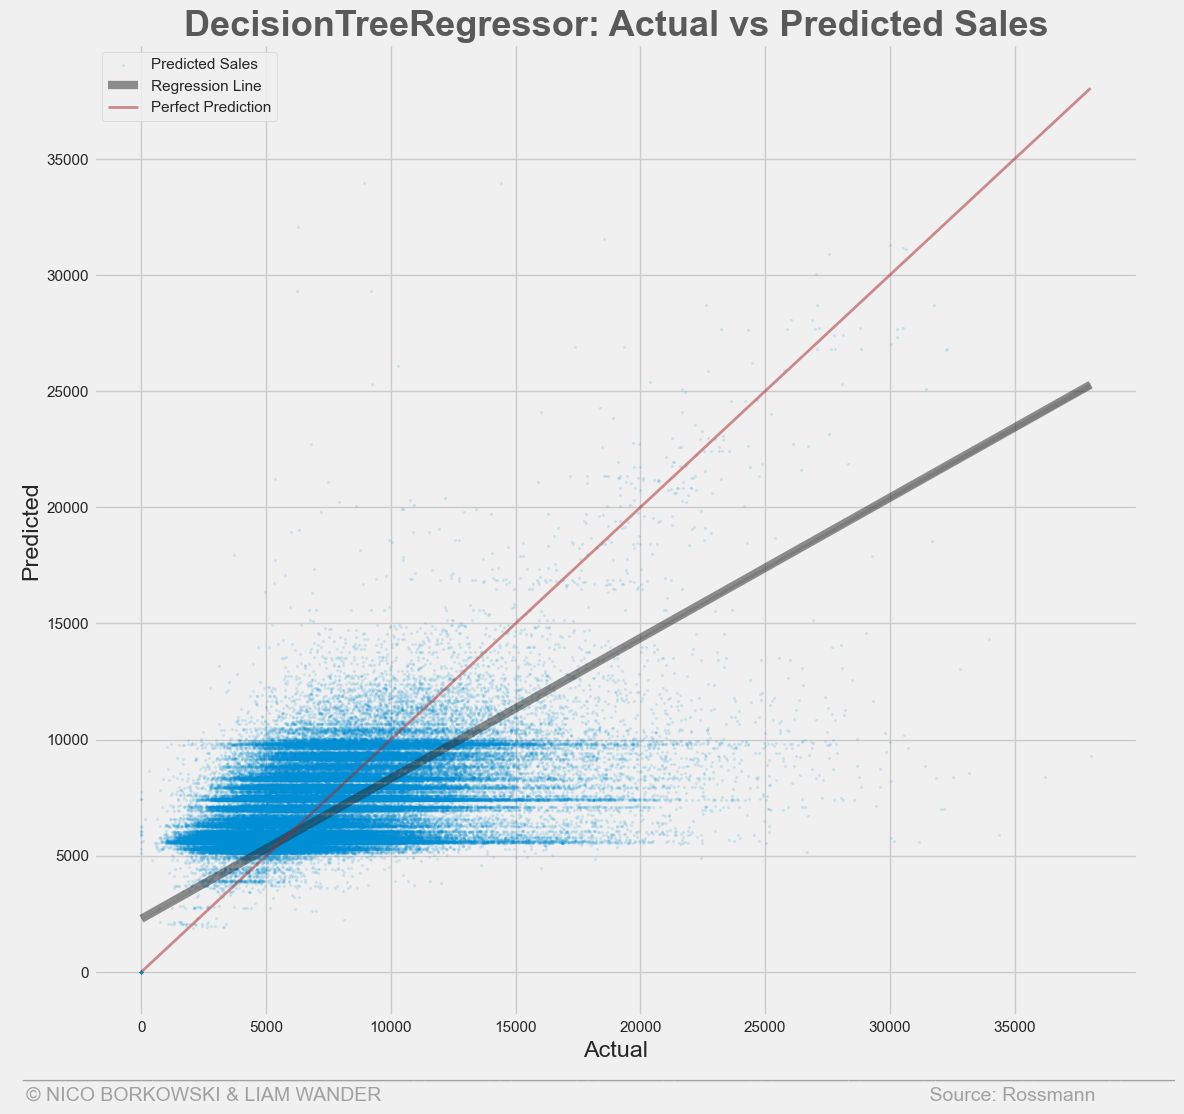

In [53]:
# creating a decision tree regressor using the best parameters
dt = DecisionTreeRegressor(criterion='friedman_mse', max_depth=10, max_features=15, min_samples_split=7, random_state=42)
dt = train_evaluate(dt, X_train, y_train, X_test, y_test)
plot_feature_importance(dt)
plot_predicted_vs_actual(dt)

### 4.4 Tuning XGBoost

```# tune the parameters of xgboost with gridsearch

# create a xgboost regressor
import xgboost as xgb
xgb = xgb.XGBRegressor(random_state=42)

# train and evaluate the model
xgb = train_evaluate(xgb, X_train, y_train, X_test, y_test)

# plot feature importance
plot_feature_importance(xgb)

# create a dictionary of all values we want to test for n_estimators
PARAMETERS = {"subsample":[0.75, 1],
              "colsample_bytree":[0.75, 1],
              "max_depth":[2, 6],
              "min_child_weight":[1, 5],
              "learning_rate":[0.1, 0.01]}

# use gridsearch to test all values for n_estimators
xgb_gscv = GridSearchCV(xgb, PARAMETERS, cv=5, verbose=2)

# fit model to data
xgb_gscv.fit(X_train, y_train)

# check top performing n_estimators value
pprint(xgb_gscv.best_params_)

Training set score: 0.75
Test set score: 0.76
Average Error: 1316.3766 degrees
RMSE = 1899.38


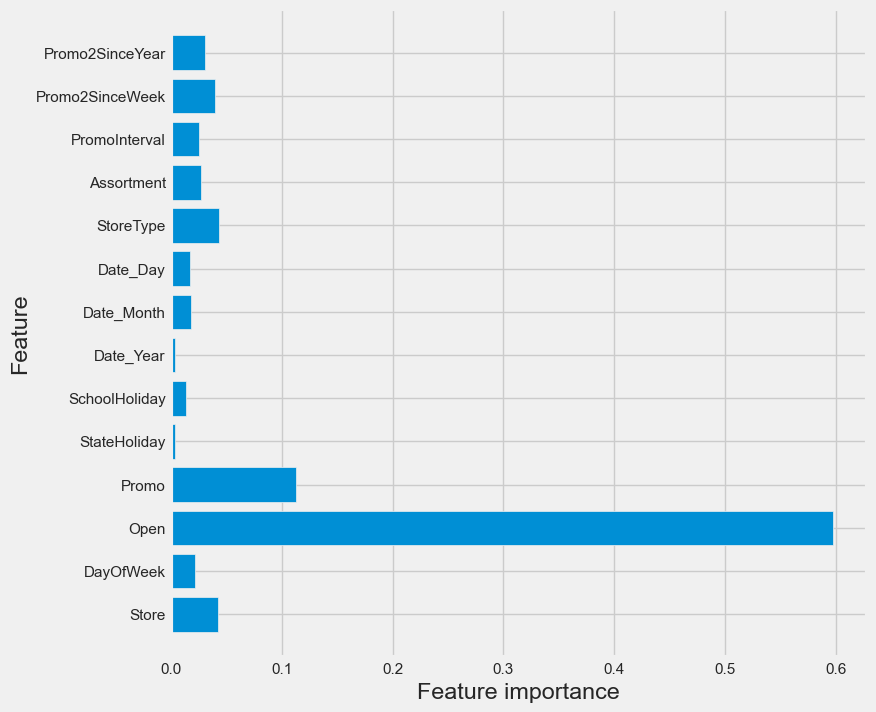

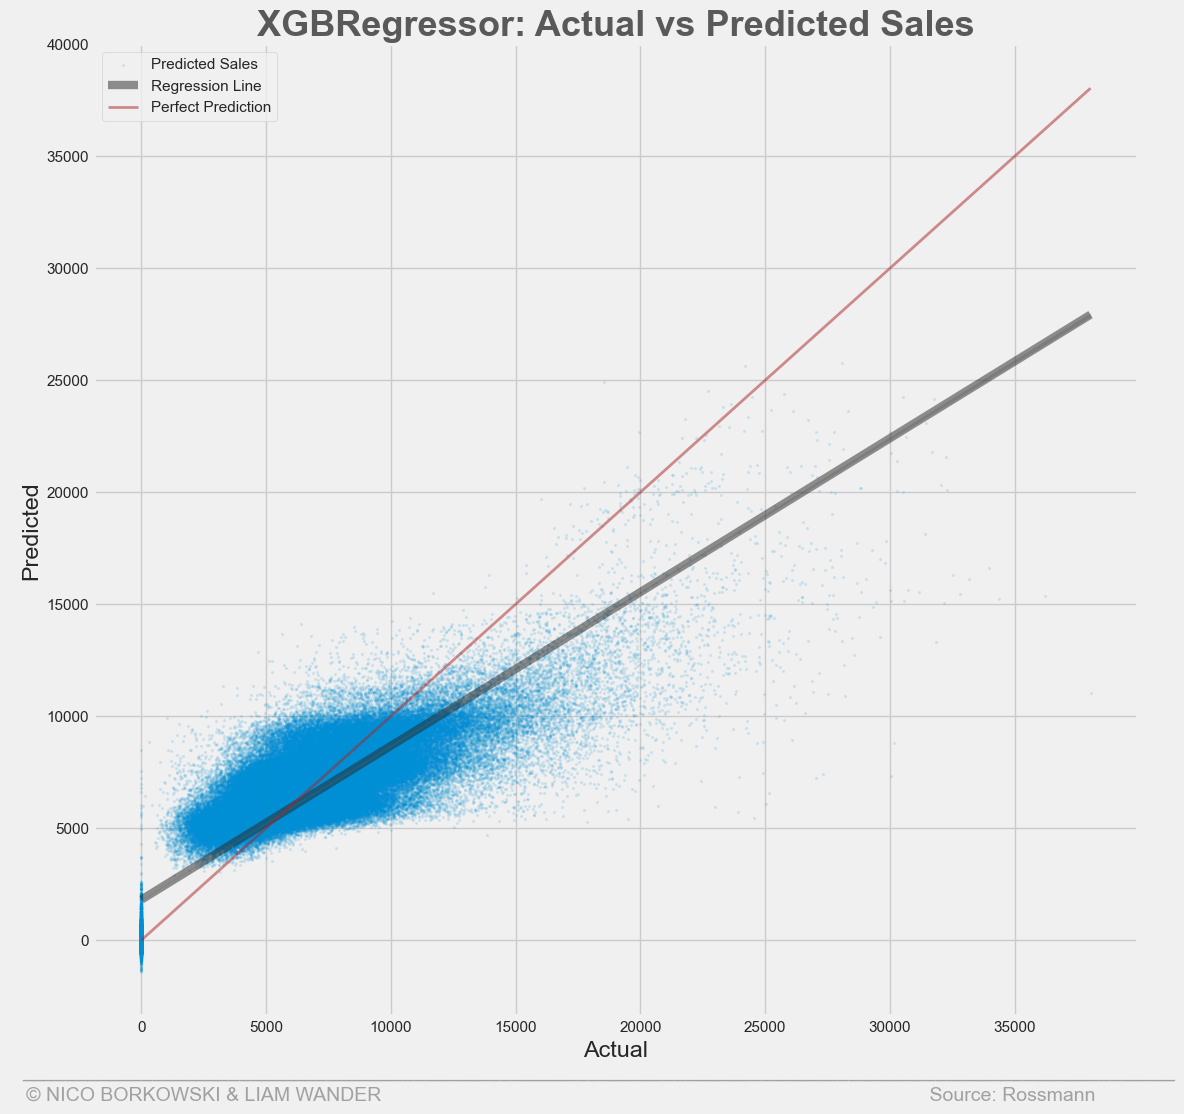

In [54]:
xgb = xgboost.XGBRegressor(colsample_bytree=1, learning_rate=0.1, max_depth=6, min_child_weight=5, subsample=1, random_state=42)
xgb = train_evaluate(xgb, X_train, y_train, X_test, y_test)

plot_feature_importance(xgb)
plot_predicted_vs_actual(xgb)

## 5. Ensemble Method: Stacking

While bagging and boosting used homogenous weak learners for ensemble, Stacking often considers heterogeneous weak learners, learns them in parallel, and combines them by training a meta-learner to output a prediction based on the different weak learner’s predictions. A meta learner inputs the predictions as the features and the target being the ground truth values in data D(Fig 2.), it attempts to learn how to best combine the input predictions to make a better output prediction. 

In averaging ensemble eg. Random Forest, the model combines the predictions from multiple trained models. A limitation of this approach is that each model contributes the same amount to the ensemble prediction, irrespective of how well the model performed. An alternate approach is a weighted average ensemble, which weighs the contribution of each ensemble member by the trust on their contribution in giving the best predictions. The weighted average ensemble provides an improvement over the model average ensemble.

A further generalization of this approach is replacing the linear weighted sum with Linear Regression (regression problem) or Logistic Regression (classification problem) to combine the predictions of the sub-models with any learning algorithm. This approach is called Stacking.

In stacking, an algorithm takes the outputs of sub-models as input and attempts to learn how to best combine the input predictions to make a better output prediction.
[Ensemble Stacking for ML & DL](https://www.analyticsvidhya.com/blog/2021/08/ensemble-stacking-for-machine-learning-and-deep-learning/)

- bagging that often considers homogeneous weak learners, learns them in parallel, and combines them by averaging their predictions
- boosting that often considers homogeneous weak learners, learns them sequentially, and combines them by weighted averaging their predictions
- stacking that often considers heterogeneous weak learners, learns them in parallel, and combines them by training a meta-learner to output a prediction based on the different weak learner’s predictions

-------knn-------
Coefficient of determination: 0.710237629565156
Root Mean Squared Error: 2070.579191665499
>knn -1894.696 (11.689)
Computation Time: 13.53156304359436
----------------------------------

-------dt-------
Coefficient of determination: 0.755510588120134
Root Mean Squared Error: 1901.957815538486
>dt -1378.389 (44.076)
Computation Time: 8.34043002128601
----------------------------------

-------rf-------
Coefficient of determination: 0.8561796522202729
Root Mean Squared Error: 1458.7505058670463
>rf -1136.335 (29.073)
Computation Time: 27.48655891418457
----------------------------------

-------xgb-------
Coefficient of determination: 0.8884074719946962
Root Mean Squared Error: 1284.9564550576215
>xgb -905.890 (9.517)
Computation Time: 77.02481293678284
----------------------------------

-------stacking-------
Coefficient of determination: 0.9180408447726922
Root Mean Squared Error: 1101.2085864089236
>stacking -888.906 (7.474)
Computation Time: 594.1878457069397
----

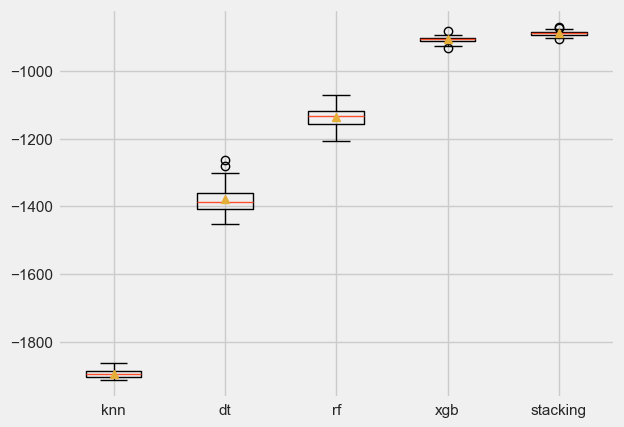

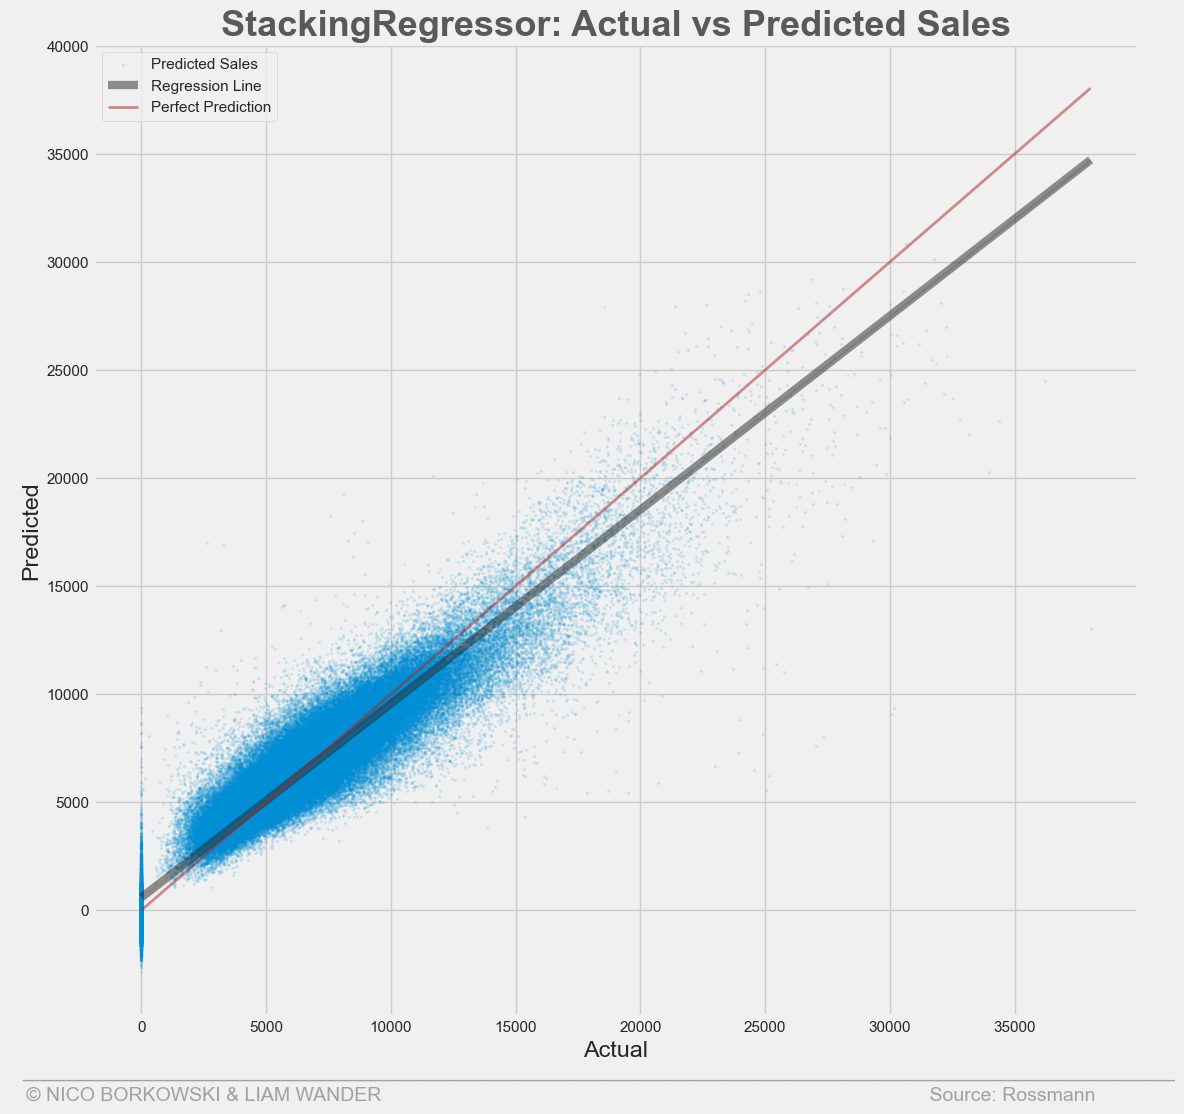

In [55]:
# get a stacking ensemble of models
def get_stacking():
    # define the base models
    level0 = list()
    level0.append(('knn', KNeighborsRegressor(n_neighbors=2)))
    level0.append(('dt', DecisionTreeRegressor(random_state=42)))
    level0.append(('rf', RandomForestRegressor(n_estimators=5, random_state=42)))
    level0.append(('xgb', xgboost.XGBRegressor()))
    # define meta learner model
    level1 = LinearRegression()
    # define the stacking ensemble
    model = StackingRegressor(estimators=level0, final_estimator=level1, cv=5)
    return model
 
# get a list of models to evaluate
def get_models():
    models = dict()
    models['knn'] = KNeighborsRegressor(n_neighbors=2)
    models['dt'] = DecisionTreeRegressor(random_state=42)
    models['rf'] = RandomForestRegressor(n_estimators=5, random_state=42)
    models['xgb'] = xgboost.XGBRegressor()
    models['stacking'] = get_stacking()
    return models
 
# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)
    scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
    return scores
 

models = get_models()
results, names = list(), list()

for name, model in models.items():
    start_time = time.time()
    scores = evaluate_model(model, X_test, y_test)
    model.fit(X_train, y_train)
    prediction = model.predict(X_test)
    r2 = model.score(X_test, y_test)
    rmse = mean_squared_error(y_test, prediction, squared = False)
    end_time = time.time()
    results.append(scores)
    names.append(name)
    print("-------{}-------".format(name))
    print("Coefficient of determination: {}".format(r2))
    print("Root Mean Squared Error: {}".format(rmse))
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
    print("Computation Time: {}".format(end_time - start_time))
    print("----------------------------------\n")
# plot each models performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

plot_predicted_vs_actual(models['stacking'])

Mit dem stacking ensemble werden die Ergebnisse der einzelnen Modelle kombiniert. Hierfür wird ein Meta-Modell verwendet, welches die Vorhersagen der einzelnen Modelle als Features verwendet und die Vorhersage des Meta-Modells als Target. Das Meta-Modell lernt dann, wie die einzelnen Vorhersagen kombiniert werden müssen, um eine bessere Vorhersage zu erzielen. Hiermit wird weitergearbeitet.